<a href="https://colab.research.google.com/github/rohit-mohanty-nyu/assignment3/blob/main/demo11-conditional-gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libaries

As always, we load lots of libraries.

In [1]:
import torch
from torchvision import datasets
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import os
from matplotlib.pyplot import imsave
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## a) Data (Using FashionMNIST)

For this demo, we will be using the MNIST data set. We can apply GANs to other datasets but the training process takes much longer. Our goal will be to supply random noise and a class label (e.g. a digit between 0 and 9) to the generator and produce an image of that particular digit.

In [2]:
# A transform to convert the images to tensor and normalize their RGB values
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])]
)

data = datasets.FashionMNIST(root='../data/', train=True, transform=transform, download=True)

batch_size = 64
data_loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=True, drop_last=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.5MB/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.79MB/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 10.2MB/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



## Helper Functions

We'll need several helper functions for training the conditional GAN. The first converts labels to one hot encoded vectors, we will use it to pass the desired label to the generator. The second will plot a grid of 10x10 images from the generator.

In [3]:
def to_onehot(x, num_classes=10):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

In [4]:
to_onehot(3)

tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

#b) Edit get sample image to not pass labels to generators

In [14]:


def get_sample_image(G, DEVICE, n_noise=100):
    img = np.zeros([280, 280])
    for j in range(10):
        c = torch.zeros([10, 10]).to(DEVICE)  # One-hot encoded labels
        c[:, j] = 1  # Set the j-th label to 1
        z = torch.randn(10, n_noise).to(DEVICE)  # Random noise vector
        y_hat = G(z).view(10, 28, 28)  # Generate images using noise
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)  # Concatenate images
    return img

## Architecture

We now instantiate the generator and discriminator architectures. The generator takes a random noise vector and a one hot encoded label as input and produces an image. The discriminator takes an image and a one hot encoded label as input and produces a single value between 0 and 1. The discriminator is trained to output 1 for real images and 0 for fake images. The generator is trained to fool the discriminator by outputting images that look real.

# b) Edit generator and Discriminator to not take labels, i.e to act as a GAN

In [17]:
class Generator(nn.Module):
    def __init__(self, input_size=100, image_size=28*28):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        return self.network(x).view(x.size(0), 1, 28, 28)  # Reshape to image size


In [18]:
class Discriminator(nn.Module):
    def __init__(self, input_size=28*28, num_output=1):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_output),
            nn.Sigmoid(),  # Output probability between 0 and 1
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input image
        return self.network(x)  # Output a single probability (real or fake)


## Set up and Training

Now, we're ready to instantiate our models, hyperparameters, and optimizers. Since the task is so easy for MNIST, we will train for only 10 epochs. We will update the generator and discriminator in every step but often one can be trained more frequently than the other.

In [19]:
MODEL_NAME = 'GAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D = Discriminator().to(DEVICE) # randomly intialized
G = Generator().to(DEVICE) # randomly initialized

max_epoch = 10
step = 0
n_noise = 100 # size of noise vector

criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

# We will denote real images as 1s and fake images as 0s
# This is why we needed to drop the last batch of the data loader
all_ones = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator label: real
all_zeros = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label: fake

In [20]:
images, class_labels = next(iter(data_loader))
class_labels_encoded = class_labels.view(batch_size, 1)
class_labels_encoded = to_onehot(class_labels_encoded).to(DEVICE)
print(class_labels[:10])
print(class_labels_encoded[:10])

tensor([1, 4, 7, 2, 3, 5, 1, 8, 2, 0])
tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')


# b) Remove label as a parameter when calling generator and discriminator

In [21]:
# a directory to save the generated images
if not os.path.exists('samples'):
    os.makedirs('samples')

for epoch in range(max_epoch):
    for idx, (images, class_labels) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        class_labels = class_labels.view(batch_size, 1) # add singleton dimension so batch_size x 1
        class_labels = to_onehot(class_labels).to(DEVICE)
        x_outputs = D(x) # input doesnt include labels
        D_x_loss = criterion(x_outputs, all_ones) # Discriminator loss for real images

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z)) # input to both generator and discriminator doesnt include labels
        D_z_loss = criterion(z_outputs, all_zeros) # Discriminator loss for fake images
        D_loss = D_x_loss + D_z_loss # Total Discriminator loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        # Training Generator
        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        G_loss = -1 * criterion(z_outputs, all_zeros) # Generator loss is negative disciminator loss

        G.zero_grad()
        G_loss.backward()
        G_opt.step()

        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, DEVICE, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/10, Step: 0, D Loss: 1.3815855979919434, G Loss: -0.7165889739990234
Epoch: 0/10, Step: 500, D Loss: 1.2834434509277344, G Loss: -0.3113447427749634
Epoch: 1/10, Step: 1000, D Loss: 1.3816131353378296, G Loss: -0.440918505191803
Epoch: 1/10, Step: 1500, D Loss: 1.099787712097168, G Loss: -0.4519157111644745
Epoch: 2/10, Step: 2000, D Loss: 1.2288792133331299, G Loss: -0.5459374189376831
Epoch: 2/10, Step: 2500, D Loss: 1.3719310760498047, G Loss: -0.5274425745010376
Epoch: 3/10, Step: 3000, D Loss: 1.263547658920288, G Loss: -0.5732749104499817
Epoch: 3/10, Step: 3500, D Loss: 1.431711196899414, G Loss: -0.6291289329528809
Epoch: 4/10, Step: 4000, D Loss: 1.2487719058990479, G Loss: -0.6390987634658813
Epoch: 4/10, Step: 4500, D Loss: 1.2961913347244263, G Loss: -0.5596766471862793
Epoch: 5/10, Step: 5000, D Loss: 1.448104977607727, G Loss: -0.43274542689323425
Epoch: 5/10, Step: 5500, D Loss: 1.407064437866211, G Loss: -0.6001282930374146
Epoch: 6/10, Step: 6000, D Loss: 1.42

Now let's plot these images. At first, the generator just produces noise (as we expect).

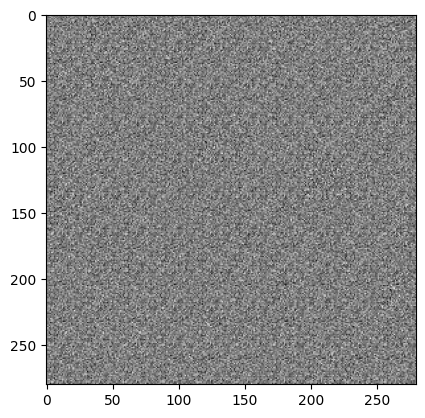

In [22]:
img = mpimg.imread('samples/GAN_step000.jpg')
imgplot = plt.imshow(img)
plt.show()

But then it gets better.

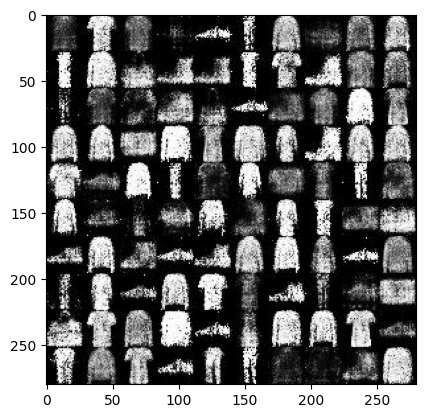

In [23]:
img = mpimg.imread('samples/GAN_step5000.jpg')
imgplot = plt.imshow(img)
plt.show()

Rough images of fashion accessories

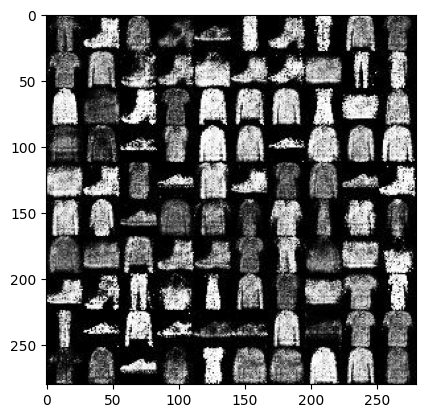

In [24]:
img = mpimg.imread('samples/GAN_step9000.jpg')
imgplot = plt.imshow(img)
plt.show()

Better images of fashion accessories